# Librairies

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from scipy.stats import norm
from scipy import linalg
from sklearn.cluster import KMeans
from sklearn.base import TransformerMixin, BaseEstimator, ClusterMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import check_X_y
from sklearn.model_selection import cross_val_score
from google.colab import files

!pip install --upgrade prince
import prince

# Fonctions personnalisées

In [19]:
import importlib
if importlib.util.find_spec("missingno") is None:
  !pip install --user --upgrade missingno
import missingno as msno

def inspect_data(df=None, visualize_missing_value=False, display_form='matrix', figsize=(6,4)):
  """ Fonction pour afficher les informations de données.
  - Paramters:
    df: jeu de données en format DataFrame or Series
    visualize_missing_value: is or not to visualize the missing value, default False
    display_form: visualization chart to use, 'matrix'(defaul), 'bar', 'heatmap'
    figsize: The size of the figure to display
  - Return value: None
  """
  print(">>> Les premiers cinq lignes de donnée: \n", df.head())
  if visualize_missing_value == True:
    print(">>> Visualisation de valeurs manquantes:")
    if display_form == 'matrix':
      msno.matrix(df, figsize=figsize)
    if display_form == 'bar':
      msno.bar(df, figsize=figsize)
    if display_form == 'heatmap':
      msno.heatmap(df, figsize=figsize)
  plt.show()
  return

def valueToMeaning(df, attribut, meaning): 
    ''' Convertit une liste de valeur d'un attribut à sa définition.
    df : jeu de données en format DataFrame or Series
    attribut : colonne du jeu de données
    meaning : liste de définition
    '''
    nb_ligne = df.shape[0]
    # Range les valeurs uniques de l'attribut dans l'ordre croissant
    sorted_unique_values = df[attribut].unique()
    sorted_unique_values.sort()

    for i in range(len(meaning)):
        df[attribut].replace({sorted_unique_values[i] : meaning[i]}, inplace=True)

    # Vérifier si on a bien le bon nombre de valeurs pour chaque colonne changée par le nombre d'attributs pour chaque colonne
    if df[attribut].value_counts().sum() == nb_ligne:
      print("==================Bien transformé pour [{0}]=========".format(attribut))

def value_counts_percentage(df, attribut):
    ''' Fonction pour calculer le nombre et le pourcentage des valeurs différentes d'un attribut 
    df: jeu de données en format DataFrame or Series
    attribut : colonne du jeu de données
    '''
    nb_val = df[attribut].value_counts()
    perc_val = df[attribut].value_counts(normalize=True) * 100
    return pd.concat([nb_val,perc_val.round(2)], axis=1, keys=['N', '%'])

def heatmap_corr(df, method='spearman', already=False, mask=True, nominal=False, title=None, figsize=(20,9)):
    ''' Fonction pour visualiser la corrélation
    df - peut être des données «pures» (sans corrélations calculées) ou un DataFrame avec des corrélations déjà calculées (dans ce cas, l'attribut «already» doit être défini sur True)
    method - 'Pearson'(linéaire) ou 'Spearman'(non-linéaire)
    mask - pour cacher les valeurs en triangulaire supérieur et manquantes
    nominal - pour les corrélations de données nominales, les valeurs sont dans la plage (0, 1) au lieu de (-1, -1) et nominal = True doit être suivi par already = True
    '''
    if not already:
        corr = df.corr(method=method)
    elif already:
        corr = df
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    vmax = corr.max().max()
    if nominal:
        center = 0.5
        cmap=None
    elif not nominal:
        center = 0
    if mask:
       mask = np.zeros_like(corr, dtype=np.bool)
       mask[np.triu_indices_from(mask)] = True
       vmax = corr.replace(1, -2).max().max()
    elif not mask:
      mask=None
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, cmap=cmap, mask=mask, vmax=vmax, center=center, annot=True, linewidths=.5, cbar_kws={'shrink': 0.5})
    if title:
      plt.title(title)
    plt.show()

def scatterplot_pca(columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs):
    """
    Utilise `sns.scatterplot` en appliquant d'abord une ACP si besoin pour réduire la dimension.
    """
    # Select columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    sp_kwargs = {}
    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        sp_kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        sp_kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **sp_kwargs)

    return ax, pca

class NearestPrototypes(TransformerMixin, ClusterMixin, BaseEstimator):
    def __init__(self, n_prototypes_list=[3, 3], n_neighbors=5):
        # Définir une assertion pour contrôler que `n_prototypes_list`
        # et `n_neighbors` ont des valeurs cohérentes.
        assert(sum(n_prototypes_list) >= n_neighbors)

        self.n_prototypes_list = n_prototypes_list
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        # Validation des entrées
        X, y = check_X_y(X, y)

        labels = np.unique(y)
        self.classes_ = labels
        assert(len(labels) == len(self.n_prototypes_list))
        assert(len(y) >= sum(self.n_prototypes_list))

        def prototypes(X, label, n_prototypes):
            """Sélectionne les individus d'étiquette `label` dans `X` et lance un
            algorithme des k-means pour calculer `n_prototypes`
            prototypes.
            """

            # Sélection du jeu de données d'étiquette `label`
            Xk = X[y == label, :]

            # Création d'un objet de classe `KMeans` avec le bon nombre
            # de prototypes
            cls = KMeans(n_clusters=n_prototypes)

            # Apprentissage des prototypes
            cls.fit(Xk)

            return cls.cluster_centers_

        # Concaténation de tous les prototypes pour toutes les
        # étiquettes et le nombre de prototypes correspondants.
        # Utiliser la fonction `prototypes` définies précédemment et
        # la fonction `np.concatenate`.
        self.prototypes_ = np.concatenate([
            prototypes(X, label, n_prototypes)
            for n_prototypes, label in zip(self.n_prototypes_list, labels)
        ])


        # Création des étiquettes pour tous les prototypes construits
        # précédemment. On pourra utiliser `np.repeat`.
        self.labels_ = np.repeat(labels, self.n_prototypes_list)


        # Création d'un objet KNeighborsClassifier
        self.nearest_prototypes_ = KNeighborsClassifier(n_neighbors=self.n_neighbors)


        # Apprentissage du Knn sur les prototypes et leur étiquette
        self.nearest_prototypes_.fit(self.prototypes_, self.labels_)

    def predict(self, X):
        # Prédire les étiquettes en utilisant self.nearest_prototypes_
        return self.nearest_prototypes_.predict(X)

def add_decision_boundary(
    model,
    resolution=100,
    ax=None,
    levels=None,
    label=None,
    color=None,
    region=True,
    model_classes=None,
):
    """Trace une frontière et des régions de décision sur une figure existante.

    :param model: Un modèle scikit-learn ou une fonction `predict`
    :param resolution: La discrétisation en nombre de points par abcisses/ordonnées à utiliser
    :param ax: Les axes sur lesquels dessiner
    :param label: Le nom de la frontière dans la légende
    :param color: La couleur de la frontière
    :param region: Colorer les régions ou pas
    :param model_classes: Les étiquettes des classes dans le cas où `model` est une fonction

    """

    # Set axes
    if ax is None:
        ax = plt.gca()

    # Add decision boundary to legend
    color = "red" if color is None else color
    sns.lineplot(x=[0], y=[0], label=label, ax=ax, color=color, linestyle="dashed")

    # Create grid to evaluate model
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    def draw_boundaries(XX, YY, Z_num, color):
        # Boundaries
        mask = np.zeros_like(Z_num, dtype=bool)
        for k in range(len(model_classes) - 1):
            mask |= Z_num == k - 1
            Z_num_mask = np.ma.array(Z_num, mask=mask)
            ax.contour(
                XX,
                YY,
                Z_num_mask,
                levels=[k + 0.5],
                linestyles="dashed",
                corner_mask=True,
                colors=[color],
                antialiased=True,
            )

    def get_regions(predict_fun, xy, shape, model_classes):
        Z_pred = predict_fun(xy).reshape(shape)
        cat2num = {cat: num for num, cat in enumerate(model_classes)}
        num2cat = {num: cat for num, cat in enumerate(model_classes)}
        vcat2num = np.vectorize(lambda x: cat2num[x])
        Z_num = vcat2num(Z_pred)
        return Z_num, num2cat

    def draw_regions(ax, model_classes, num2cat, Z_num):
        # Hack to get colors
        # TODO use legend_out = True
        slabels = [str(l) for l in model_classes]
        hdls, hlabels = ax.get_legend_handles_labels()
        hlabels_hdls = {l: h for l, h in zip(hlabels, hdls)}

        color_dict = {}
        for label in model_classes:
            if str(label) in hlabels_hdls:
                hdl = hlabels_hdls[str(label)]
                color = hdl.get_facecolor().ravel()
                color_dict[label] = color
            else:
                raise Exception("No corresponding label found for ", label)

        colors = [color_dict[num2cat[i]] for i in range(len(model_classes))]
        cmap = mpl.colors.ListedColormap(colors)

        ax.imshow(
            Z_num,
            interpolation="nearest",
            extent=ax.get_xlim() + ax.get_ylim(),
            aspect="auto",
            origin="lower",
            cmap=cmap,
            alpha=0.2,
        )

    if isinstance(model, BaseEstimator):
        if model_classes is None:
            model_classes = model.classes_

        if levels is not None:
            if len(model.classes_) != 2:
                raise Exception("Lignes de niveaux supportées avec seulement deux classes")

            # Scikit-learn model, 2 classes + levels
            Z = model.predict_proba(xy)[:, 0].reshape(XX.shape)
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            # Only 2 classes, simple contour
            ax.contour(
                XX,
                YY,
                Z,
                levels=levels,
                colors=[color]
            )

            draw_regions(ax, model_classes, num2cat, Z_num)
        else:
            # Scikit-learn model + no levels
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            draw_boundaries(XX, YY, Z_num, color)
            if region:
                draw_regions(ax, model_classes, num2cat, Z_num)
    else:
        if model_classes is None:
            raise Exception("Il faut spécifier le nom des classes")
        if levels is not None:
            raise Exception("Lignes de niveaux avec fonction non supporté")

        # Model is a predict function, no levels
        Z_num, num2cat = get_regions(model, xy, XX.shape, model_classes)
        draw_boundaries(XX, YY, Z_num, color)
        if region:
            draw_regions(ax, model_classes, num2cat, Z_num)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, \
f1_score, precision_score, recall_score,  precision_recall_curve, roc_curve, plot_roc_curve, auc, roc_auc_score, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier


def split_train_evaluation_plot(X, y, verbose=True, plot_cm=True, title=None):
  # Séparation de données
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  list_accuracy, list_precision, list_sensitivity, list_f1_score = [], [], [], []

  # Entraînement et évaluation
  # Define the model
  cls_lr = LogisticRegression(max_iter=10000, class_weight="balanced")
  # fit on the training set
  cls_lr.fit(X_train, y_train)

  # Predict on test set
  y_pred_lr = cls_lr.predict(X_test)

  Accuracy = cross_val_score(estimator = LogisticRegression(max_iter=10000, class_weight="balanced"), X = X, y = y, cv = 10)

  list_accuracy.append(round(Accuracy.mean()*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_lr)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_lr)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_lr)*100, 2))

  if verbose:
    print("=======================================================LogisticRegression=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_lr)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_lr)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_lr)*100))
    
  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_lr, labels=cls_lr.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_lr.classes_)
    disp.plot()
    plt.show()

  from sklearn.model_selection import GridSearchCV
  from sklearn.neighbors import KNeighborsClassifier

  # De 1 à 500 voisins (exclu), échelle logarithmique
  n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
  param_grid = {"n_neighbors": n_neighbors_list}

  # GridS earch
  search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10)
  search.fit(X_train, y_train)
  # print(search.best_params_['n_neighbors'])

  cls_knn = KNeighborsClassifier(n_neighbors=search.best_params_['n_neighbors'])
  cls_knn.fit(X_train, y_train)

  # predict on test set
  y_pred_knn = cls_knn.predict(X_test)
  
  Accuracy = accuracy_score(y_test, y_pred_knn)
  
  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_knn)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_knn)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_knn)*100, 2))

  if verbose:
    print("=======================================================KNN=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_knn)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_knn)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_knn)*100))

  if plot_cm:
      # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_knn, labels=cls_knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_knn.classes_)
    disp.plot()

  cls_dt = DecisionTreeClassifier(criterion="gini", random_state=42)
  cls_dt.fit(X_train, y_train)

  y_pred_dt = cls_dt.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_dt)
  
  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_dt)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_dt)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_dt)*100, 2))

  if verbose:
    print("=======================================================DecisionTree=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_dt)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_dt)*100))

    # Specificity/Spécificité = tn / (tn + fp) -> pas intéressant

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_dt)*100))

  if plot_cm:
      # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_dt, labels=cls_dt.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_dt.classes_)
    disp.plot()
    plt.show()

  #Create the SVM model
  cls_svm = SVC(kernel = 'rbf', random_state=42)

  #Fit the model for the data
  cls_svm.fit(X_train, y_train)

  #Make the prediction
  y_pred_svm = cls_svm.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_svm)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_svm)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_svm)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_svm)*100, 2))

  if verbose:
    print("=======================================================SVM=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_svm)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_svm)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_svm)*100))

  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_svm, labels=cls_svm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_svm.classes_)
    disp.plot()
    plt.show()

  cls_GaussianNB = GaussianNB()
  cls_GaussianNB.fit(X_train, y_train)

  y_pred_GaussianNB = cls_GaussianNB.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_GaussianNB)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_GaussianNB)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_GaussianNB)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_GaussianNB)*100, 2))

  if verbose:
    print("=======================================================Naive Bayes=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_GaussianNB)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_GaussianNB)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_GaussianNB)*100))
    
  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_GaussianNB, labels=cls_GaussianNB.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_GaussianNB.classes_)
    disp.plot()
    plt.show()

  # Linear Discriminant Analysis
  cls_LDA = LinearDiscriminantAnalysis()
  cls_LDA.fit(X_train, y_train)

  y_pred_LDA = cls_LDA.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_LDA)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_LDA)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_LDA)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_LDA)*100, 2))

  if verbose:
    print("=======================================================LDA=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_LDA)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_LDA)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_LDA)*100))

  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_LDA , labels=cls_LDA.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_LDA.classes_)
    disp.plot()
    plt.show()

  # Quadratic Discriminant Analysis
  cls_QDA = QuadraticDiscriminantAnalysis()
  cls_QDA.fit(X_train, y_train)

  y_pred_QDA = cls_QDA.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_QDA)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_QDA)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_QDA)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_QDA)*100, 2))

  if verbose:
    print("=======================================================QDA=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_QDA)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_QDA)*100))

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_QDA)*100))

  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_QDA, labels=cls_QDA.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_QDA.classes_)
    disp.plot()
    plt.show()

  cls_RF = RandomForestClassifier(max_depth=2, random_state=0)
  cls_RF.fit(X_train, y_train)

  y_pred_RF = cls_RF.predict(X_test)

  Accuracy = accuracy_score(y_test, y_pred_RF)

  list_accuracy.append(round(Accuracy*100, 2))
  list_precision.append(round(precision_score(y_test, y_pred_RF)*100, 2))
  list_sensitivity.append(round(recall_score(y_test, y_pred_RF)*100, 2))
  list_f1_score.append(round(f1_score(y_test, y_pred_RF)*100, 2))

  if verbose:
    print("=======================================================Random Forest=======================================================")
    # Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
    print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

    # Precision = tp / (tp + fp) --> parlant
    print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_RF)*100))

    # Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
    print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_RF)*100))

    # Specificity/Spécificité = tn / (tn + fp) -> pas intéressant

    # F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
    print("F1 score: {:.2f} %".format(f1_score(y_test, y_pred_RF)*100))

  if plot_cm:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_RF, labels=cls_RF.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_RF.classes_)
    disp.plot()
    plt.show()

  # Affchier courbe ROC et AUC
  fig, ax = plt.subplots(figsize=(6,6))

  # Courbe ROC - LogisticRegression
  plot_roc_curve(cls_lr, X_test, y_test, ax=ax)

  # Courbe ROC - KNN
  plot_roc_curve(cls_knn, X_test, y_test, ax=ax)

  # Courbe ROC - DecisionTree
  plot_roc_curve(cls_dt, X_test, y_test, ax=ax)

  # Courbe ROC - SVM
  plot_roc_curve(cls_svm, X_test, y_test, ax=ax)

  # Courbe ROC - Naive Bayes
  plot_roc_curve(cls_GaussianNB , X_test, y_test, ax=ax)

  # Courbe ROC - LDA
  plot_roc_curve(cls_LDA, X_test, y_test, ax=ax)

  # Courbe ROC - QDA
  plot_roc_curve(cls_QDA, X_test, y_test, ax=ax)

  # Courbe ROC - Random Forest
  plot_roc_curve(cls_RF, X_test, y_test, ax=ax)

  # Courbe ROC - Random Guess
  random_probs = [0 for _ in range(len(y_test))]
  random_auc = roc_auc_score(y_test, random_probs)
  random_fpr, random_tpr, _ = roc_curve(y_test, random_probs)
  plt.plot(random_fpr, random_tpr, linestyle='--', label='Random Guess')

  plt.legend()
  plt.title(title)
  plt.show()

  score = {'Accuracy (%)': list_accuracy, 'Precision (%)': list_precision, 'Sensitivity (%)': list_sensitivity, 'F1 Socre (%)': list_f1_score}
  df_score = pd.DataFrame.from_dict(score)
  df_score.index = ['LogisticRegression', 'KNN', 'DecisionTree', 'SVM', 'Naive Bayes', 'LDA', 'QDA', 'Random Forest']

  return df_score

from sklearn.linear_model import LogisticRegression
class LR(LogisticRegression):
  def __init__(self, threshold=0.01, dual=False, tol=1e-4, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1):
    self.threshold = threshold
    LogisticRegression.__init__(self, penalty='l1', dual=dual, tol=tol, C=C, fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, class_weight=class_weight, random_state=random_state, solver=solver, max_iter=max_iter, multi_class=multi_class, verbose=verbose, warm_start=warm_start, n_jobs=n_jobs)
    self.l2 = LogisticRegression(penalty='l2', dual=dual, tol=tol, C=C, fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, class_weight = class_weight, random_state=random_state, solver=solver, max_iter=max_iter, multi_class=multi_class, verbose=verbose, warm_start=warm_start, n_jobs=n_jobs)

  def fit(self, X, y, sample_weight=None):
    super(LR, self).fit(X, y, sample_weight=sample_weight)
    self.coef_old_ = self.coef_.copy()
    self.l2.fit(X, y, sample_weight=sample_weight)

    selected_column_list = []

    cntOfRow, cntOfCol = self.coef_.shape
    for i in range(cntOfRow):
      for j in range(cntOfCol):
        coef = self.coef_[i][j]
        if coef != 0:
          idx = [j]
          coef1 = self.l2.coef_[i][j]
          for k in range(cntOfCol):
            coef2 = self.l2.coef_[i][k]
            if abs(coef1-coef2) < self.threshold and j != k and self.coef_[i][k] == 0:
              idx.append(k)
          mean = coef / len(idx)
          self.coef_[i][idx] = mean

    for i, item in enumerate(self.coef_[0]):
      if item != 0:
        selected_column_list.append(X.columns[i])

    print("Importante features selected: ", selected_column_list)

    return self 



# Téléchargement de données

Mounted at /content/drive
>>> Les premiers cinq lignes de donnée: 
         Age   Gender  Education  Country  ...  Mushrooms  Nicotine  Semer  VSA
ID                                        ...                                 
1   0.49788  0.48246   -0.05921  0.96082  ...        CL0       CL2    CL0  CL0
2  -0.07854 -0.48246    1.98437  0.96082  ...        CL0       CL4    CL0  CL0
3   0.49788 -0.48246   -0.05921  0.96082  ...        CL1       CL0    CL0  CL0
4  -0.95197  0.48246    1.16365  0.96082  ...        CL0       CL2    CL0  CL0
5   0.49788  0.48246    1.98437  0.96082  ...        CL2       CL2    CL0  CL0

[5 rows x 31 columns]
>>> Visualisation de valeurs manquantes:


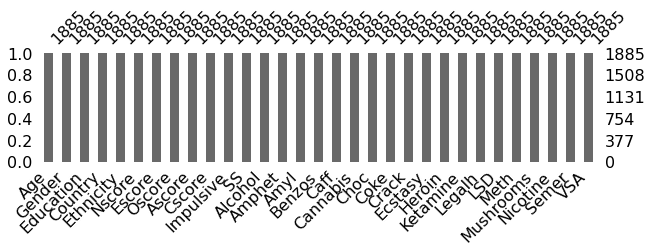

In [20]:
# Monter sur google drive
'''Monter sur Google Drive sur Google Colab afin de pouvoir importer les données à partir des fichiers sur Google Drive'''
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Remplacer le répertoire de travail par le chemin où on place tous les fichiers de données (.data)
import os
path = "/content/drive/MyDrive/Projet_SY09/data"
os.chdir(path)

# Télécharger les données
colnames = ['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Alcohol', 'Amphet', 
            'Amyl', 'Benzos', 'Caff', 'Cannabis','Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh','LSD','Meth','Mushrooms','Nicotine','Semer','VSA']  
df_drug = pd.read_csv("drug_consumption.data", index_col=0, names=colnames)

# Inspecter les données
inspect_data(df_drug, visualize_missing_value=True, display_form='bar', figsize=(10, 2))

On peut constater qu’il n’y a pas de valeur manquante dans
ce jeu de données.

# Corrélation entre les drogues

In [21]:
#%% Binarization
df_drug.drop(columns=['Semer'], inplace=True)

df_drug.replace(['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'], [0, 0, 0, 1, 1, 1, 1], inplace=True)

In [22]:
from collections import Counter
for column in df_drug.iloc[:, 12:].columns:
  print("{} shape is {}".format(column, Counter(df_drug[column])))

Alcohol shape is Counter({1: 1749, 0: 136})
Amphet shape is Counter({0: 1449, 1: 436})
Amyl shape is Counter({0: 1752, 1: 133})
Benzos shape is Counter({0: 1350, 1: 535})
Caff shape is Counter({1: 1824, 0: 61})
Cannabis shape is Counter({1: 999, 0: 886})
Choc shape is Counter({1: 1840, 0: 45})
Coke shape is Counter({0: 1468, 1: 417})
Crack shape is Counter({0: 1806, 1: 79})
Ecstasy shape is Counter({0: 1368, 1: 517})
Heroin shape is Counter({0: 1767, 1: 118})
Ketamine shape is Counter({0: 1677, 1: 208})
Legalh shape is Counter({0: 1321, 1: 564})
LSD shape is Counter({0: 1505, 1: 380})
Meth shape is Counter({0: 1565, 1: 320})
Mushrooms shape is Counter({0: 1451, 1: 434})
Nicotine shape is Counter({1: 1060, 0: 825})
VSA shape is Counter({0: 1790, 1: 95})


In [23]:
d1 = df_drug['Alcohol'].value_counts()
d2 = df_drug['Amphet'].value_counts()
d3 = df_drug['Amyl'].value_counts()
d4 = df_drug['Benzos'].value_counts()
d5 = df_drug['Caff'].value_counts()
d6 = df_drug['Cannabis'].value_counts()
d7 = df_drug['Choc'].value_counts()
d8 = df_drug['Coke'].value_counts()
d9 = df_drug['Crack'].value_counts()
d10 = df_drug['Ecstasy'].value_counts()
d11 = df_drug['Heroin'].value_counts()
d12 = df_drug['Ketamine'].value_counts()
d13 = df_drug['Legalh'].value_counts()
d14 = df_drug['LSD'].value_counts()
d15 = df_drug['Meth'].value_counts()
d16 = df_drug['Mushrooms'].value_counts()
d17 = df_drug['Nicotine'].value_counts()
d18 = df_drug['VSA'].value_counts()

drug_table = pd.concat([d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13, d14, d15, d16, d17, d18], axis=1, 
      keys=['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'VSA'])
drug_table = drug_table.T.fillna(0).astype(np.int64)
print(drug_table)

              0     1
Alcohol     136  1749
Amphet     1449   436
Amyl       1752   133
Benzos     1350   535
Caff         61  1824
Cannabis    886   999
Choc         45  1840
Coke       1468   417
Crack      1806    79
Ecstasy    1368   517
Heroin     1767   118
Ketamine   1677   208
Legalh     1321   564
LSD        1505   380
Meth       1565   320
Mushrooms  1451   434
Nicotine    825  1060
VSA        1790    95


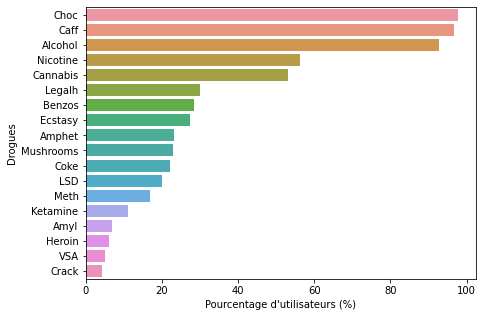

In [24]:
# Calculer le nombre de consommateurs pour chaque drogue
nb_user = drug_table.iloc[:, :1].sum(axis=1).to_frame().rename(columns={0: 'User'}).sort_values(by=['User'], ascending=False)

# Calculer le nombre de non-consommateurs pour chaque drogue
nb_non_user = drug_table.iloc[:, 1:].sum(axis=1).to_frame().rename(columns={0: 'Non_user'}).sort_values(by=['Non_user'], ascending=False)

plt.figure(figsize=(7, 5))
#data = pd.concat([nb_user, nb_non_user], axis=1).reset_index().melt(id_vars=['index'], var_name='Type', value_name='Nombre total')
#data.rename(columns = {'index':'Drogues'}, inplace = True)
#sns.barplot(x='Nombre total', y="Drogues", hue='Type', data=nb_user, orient="h")
nb_non_user.reset_index(inplace=True)
nb_non_user["Non_user"] = nb_non_user["Non_user"]/1885*100
nb_non_user.rename(columns = {'index':'Drogues'}, inplace = True)
sns.barplot(x="Non_user", y="Drogues", data=nb_non_user, orient="h")
plt.xlabel("Pourcentage d'utilisateurs (%)")
plt.savefig("prop_user.svg")
#files.download("prop_user.svg") 
plt.show()

==> On constate que le nombre de consommateurs de drogues [Alcohol, Caff, Choc] est plus grand que celui de non-consommateurs, d'après notre analyse descriptieve, on les supprime et on s'intéresse plutôt à resoudre le problème de classe imbalance pour les autres drogues. 

Cependant, avec la pleiade de drogues, on rassemble les drogues selon leurs corrélations.

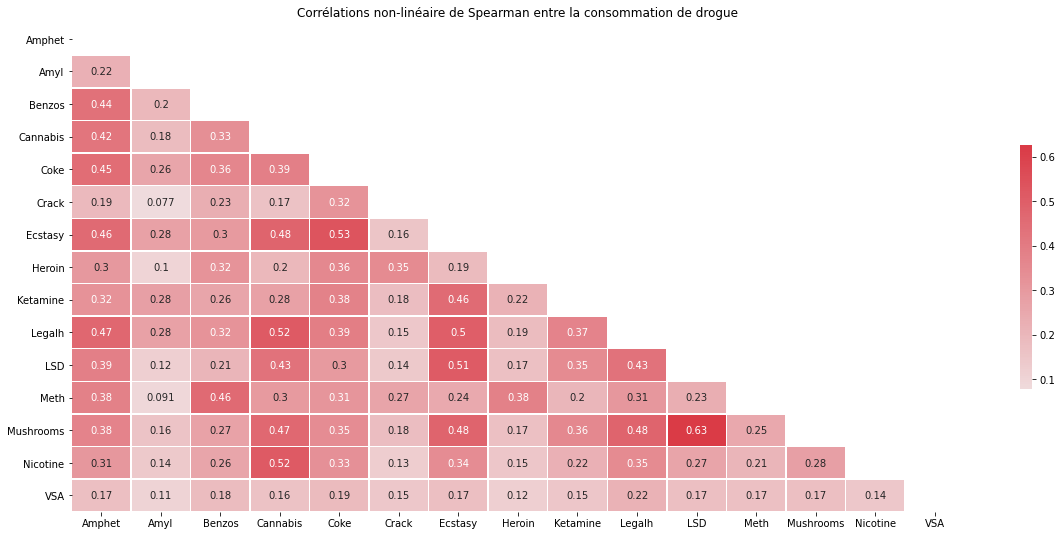

In [25]:
# Analyse de corrélation non-linéaire de Spearman entre la consommation de drogue
df_drug_corr = df_drug.iloc[:, 12:].drop(columns=['Alcohol', 'Caff', 'Choc'])
heatmap_corr(df_drug_corr, method='spearman', title="Corrélations non-linéaire de Spearman entre la consommation de drogue")

D'après les corrélations, on peut regrouper les drogues avec 3 centres : **Heroin**, **Ecstasy** et **Benzos**. 
Ce sont les 3 drogues qui ont les meilleures corrélations avec les autres drogues. 
On a alors les pleiades suivantes : 

*   Pleiade d'Heroin = ['Crack', 'Coke', 'Meth', 'Heroin']
*   Pleiade d'Ecstasy = ['Amphet', 'Cannabis', 'Coke', 'Ketamine', 'LSD', 'Mushrooms', 'Legalh', 'Ecstasy']
*   Pleiade de Benzos = ['Meth', 'Amphet', 'Coke', 'Benzos']


In [26]:
df_drug

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,VSA
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1,0,0,0,1,1,1,1,0,1,0,0,0,0,1,0,1,0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1884,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,1,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,1
1885,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,1,0,0,0,1,1,1,0,0,0,0,0,1,1,1,1,1,0
1886,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,1,0


## Préparation des données

In [27]:
df_drug.drop(columns=['Alcohol', 'Caff', 'Choc'], inplace=True)

In [28]:
# Extraire respectivement la partie 'personality measurements' et 'legal and illegal drugs' de données
attributes = df_drug.iloc[:, :12]
drug = df_drug.iloc[:, 12:]

# Nomination des données pour les attributs
  # Préparation des listes de nomination
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
gender = ['Male', 'Female']
education = ['Left school before 16',  'Left school at 16', 'Left school at 17', 'Left school at 18',  'Some college or university', 'Professional diploma', 'University degree', 'Masters degree', 'Doctorate degree']
country = ['USA', 'New Zealand', 'Other', 'Australia', 'Republic of Ireland', 'Canada',  'UK']
ethnicity = ['Black', 'Asian', 'White', 'Mixed-White/Black', 'Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']
Nscore = np.arange(12, 61)
Escore = np.arange(16, 60)
Oscore = np.arange(24, 61)
Ascore = np.arange(12, 61)
Cscore = np.arange(17, 60)

  # Transformation - Age
valueToMeaning(attributes, 'Age', age)
  # Transformation - Gender
valueToMeaning(attributes, 'Gender', gender)
  # Transformation - Education
valueToMeaning(attributes, 'Education', education)
  # Transformation - Country
valueToMeaning(attributes, 'Country', country)
  # Transformation - Ethnicity
valueToMeaning(attributes, 'Ethnicity', ethnicity)
  # Transformation - Nscore
valueToMeaning(attributes, 'Nscore', Nscore)
attributes.Nscore = attributes.Nscore.astype(int)
  # Transformation - Escore
unwanted_Escore = {17, 57}
Escore = [elt for elt in Escore if elt not in unwanted_Escore]
valueToMeaning(attributes, 'Escore', Escore)
attributes.Escore = attributes.Escore.astype(int)
  # Transformation - Oscore
unwanted_Oscore = {25, 27}
Oscore = [elt for elt in Oscore if elt not in unwanted_Oscore]
valueToMeaning(attributes, 'Oscore', Oscore)
attributes.Oscore = attributes.Oscore.astype(int)
  # Transformation - Ascore
unwanted_Ascore = {13, 14, 15, 17, 19, 20, 21, 22}
Ascore = [elt for elt in Ascore if elt not in unwanted_Ascore]
valueToMeaning(attributes, 'Ascore', Ascore)
attributes.Ascore = attributes.Ascore.astype(int) 
  # Transformation - Cscore
unwanted_Cscore = {18, 58}
Cscore = [elt for elt in Cscore if elt not in unwanted_Cscore]
valueToMeaning(attributes, 'Cscore', Cscore)
attributes.Cscore = attributes.Cscore.astype(int)


# Nomination des données pour les drogues
Class = ['Never Used', 'Used over a Decade Ago', 'Used in Last Decade', 'Used in Last Year', 'Used in Last Month', 'Used in Last Week', 'Used in Last Day']
#   # Transformation - tous les attributs sauf 'Semer'
# for column in drug.loc[:, drug.columns != 'Semer']:
#     valueToMeaning(drug, column, Class)
#   # Transformation - Semer
# valueToMeaning(drug, 'Semer', ['Never Used'])

# Combinaison des deux dataframes
df_drug_trans = pd.concat([attributes, drug], axis=1)
df_drug_trans.head()

==================Bien transformé pour [Age]=========
==================Bien transformé pour [Gender]=========
==================Bien transformé pour [Education]=========
==================Bien transformé pour [Country]=========
==================Bien transformé pour [Ethnicity]=========
==================Bien transformé pour [Nscore]=========
==================Bien transformé pour [Escore]=========
==================Bien transformé pour [Oscore]=========
==================Bien transformé pour [Ascore]=========
==================Bien transformé pour [Cscore]=========


,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Amphet,Amyl,Benzos,Cannabis,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,VSA
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,35-44,Female,Professional diploma,UK,Mixed-White/Asian,39,36,42,37,42,-0.21712,-1.18084,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,25-34,Male,Doctorate degree,UK,White,29,52,55,48,41,-0.71126,-0.21575,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0
3,35-44,Male,Professional diploma,UK,White,31,45,40,32,34,-1.37983,0.40148,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,18-24,Female,Masters degree,UK,White,34,34,46,47,46,-1.37983,-1.18084,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,35-44,Female,Doctorate degree,UK,White,43,28,43,41,50,-0.21712,-0.21575,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Génération de pleiades

In [29]:
drugs = df_drug.iloc[:, 12:]

In [30]:
HeroinPl = drugs[['Crack', 'Coke', 'Meth', 'Heroin']].copy()
EcstasyPl = drugs[['Amphet', 'Cannabis', 'Coke', 'Ketamine', 'LSD', 'Mushrooms', 'Legalh', 'Ecstasy']].copy()
BenzoPl = drugs[['Meth', 'Amphet', 'Coke', 'Benzos']].copy()

In [31]:
#%% Number of drug users for pleiades 
# Si un individu consomme une des drogues de la pleiade,
# alors on considère qu'elle consomme la pleiade, sa valeur est alors à 1.

HeroinPl['HeroinPl'] = np.where((HeroinPl['Crack']==1) | 
                                (HeroinPl['Coke']==1) |
                                (HeroinPl['Meth']==1) |
                                (HeroinPl['Heroin']==1)
                                 ,1,0)

EcstasyPl['EcstasyPl'] = np.where((EcstasyPl['Amphet']==1) | 
                                (EcstasyPl['Cannabis']==1) |
                                (EcstasyPl['Coke']==1) |
                                (EcstasyPl['Ketamine']==1) |
                                (EcstasyPl['LSD']==1) |
                                (EcstasyPl['Mushrooms']==1) |
                                (EcstasyPl['Legalh']==1) |
                                (EcstasyPl['Ecstasy']==1)
                                 ,1,0)

BenzoPl['BenzoPl'] = np.where((BenzoPl['Meth']==1) | 
                                (BenzoPl['Amphet']==1) |
                                (BenzoPl['Coke']==1) |
                                (BenzoPl['Benzos']==1)
                                 ,1,0)

print("Pourcentage de Users d'HeroinPl :", HeroinPl['HeroinPl'].value_counts()[1]/1885*100)
print("Pourcentage de Users d'EcstasyPl :",EcstasyPl['EcstasyPl'].value_counts()[1]/1885*100)
print("Pourcentage de Users d'BenzoPl :",BenzoPl['BenzoPl'].value_counts()[1]/1885*100)

Pourcentage de Users d'HeroinPl : 31.03448275862069
Pourcentage de Users d'EcstasyPl : 57.77188328912467
Pourcentage de Users d'BenzoPl : 44.03183023872679


In [32]:
#%% Drop unwanted columns that are not pleiades

HeroinPl = HeroinPl.drop(['Crack', 'Coke', 'Meth', 'Heroin'], axis=1)
EcstasyPl = EcstasyPl.drop(['Amphet', 'Cannabis', 'Coke', 'Ketamine', 'LSD', 'Mushrooms', 'Legalh', 'Ecstasy'], axis=1)
BenzoPl = BenzoPl.drop(['Meth', 'Amphet', 'Coke', 'Benzos'], axis=1)

Pleiades = pd.concat([HeroinPl, EcstasyPl, BenzoPl], axis=1)

# Concatenate personality and drugs, and standardization

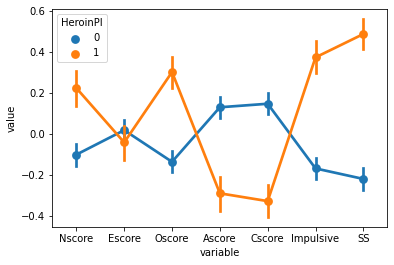

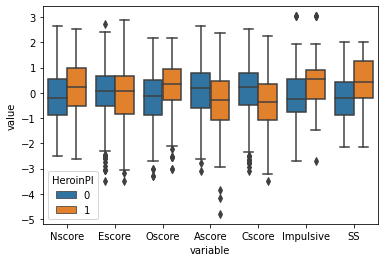

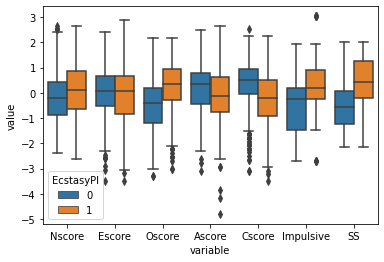

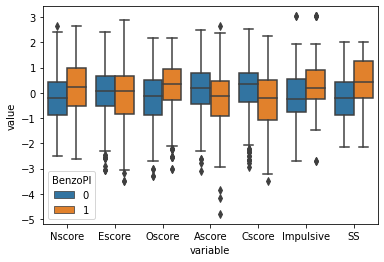

In [33]:
#%% Concatenate personality and drugs

personality = df_drug_trans.iloc[:, 5:12]

# Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
personality.iloc[:, :] = scaler.fit_transform(personality.iloc[:, :])

persByPleaides = pd.concat([personality, Pleiades], axis=1)
persByPleaides_melt = persByPleaides.melt(id_vars=['HeroinPl', 'EcstasyPl', 'BenzoPl'])
ax = sns.pointplot(x="variable", y="value", hue = "HeroinPl", data=persByPleaides_melt,legend=False)
plt.show()

sns.boxplot(x="variable", y="value", hue="HeroinPl", data=persByPleaides_melt)
plt.show()

sns.boxplot(x="variable", y="value", hue="EcstasyPl", data=persByPleaides_melt)
plt.show()

sns.boxplot(x="variable", y="value", hue="BenzoPl", data=persByPleaides_melt)
plt.show()

Les tendances pour les mesures de personalité sont toujours les mêmes pour ces pleiades.

## Application de l'ACP

Pourcentage de variance expliquée: [0.29823689 0.21852591 0.11421999 0.10342819]


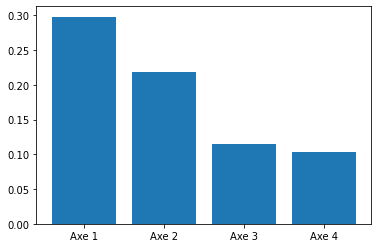

                  0         1         2         3
Ascore    -0.463008 -0.291232  0.515701 -0.669458
BenzoPl    0.534936 -0.035772  0.412647  0.193765
Cscore    -0.626232 -0.438254  0.061246  0.219284
EcstasyPl  0.593144 -0.114891  0.393277  0.093974
Escore    -0.098284 -0.825610 -0.217272  0.102027
HeroinPl   0.482376 -0.040199  0.363573  0.236422
Impulsive  0.767013 -0.219917 -0.421401 -0.112657
Nscore     0.458974  0.611979  0.088412 -0.348041
Oscore     0.461800 -0.515294  0.305726 -0.389328
SS         0.762446 -0.409101 -0.222352 -0.034198


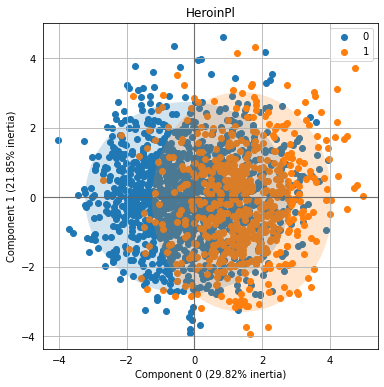

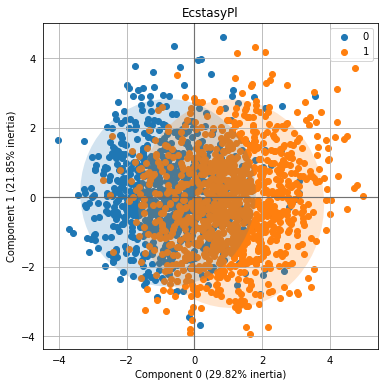

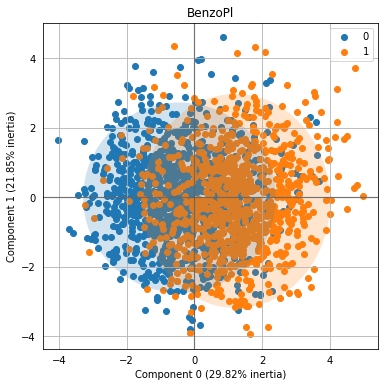

In [34]:
import prince

# Normaliser les colonnes Nscore, Escore, Oscore, Ascore, Cscore
persByPleaides.iloc[:, :5] = persByPleaides.iloc[:, :5] - persByPleaides.iloc[:, :5].mean(axis=0)

cls = prince.PCA(rescale_with_mean=False, rescale_with_std=False, n_components=4, n_iter=10)
cls.fit(persByPleaides)
pca = cls.transform(persByPleaides)

print("Pourcentage de variance expliquée:", cls.explained_inertia_)
plt.bar(["Axe 1", "Axe 2", "Axe 3", "Axe 4"], cls.explained_inertia_)
plt.show()

print(cls.column_correlations(persByPleaides))

for column in persByPleaides.iloc[:, 7:].columns:
  cls.plot_row_coordinates(persByPleaides, color_labels=persByPleaides.iloc[:, 7:][column])
  plt.title(column)

# Feature selection

In [35]:
from sklearn.feature_selection import SelectFromModel

# Régression logistique avec les termes de pénalité L1 et L2 comme modèle de base pour sélectinner les caractéristiques
# threshold - le seuil de la différence entre les coefficients de poids de pénalité L1 et L2
def select_features_by_drug(X, y, threshold=0.3, C=0.5):
  return pd.DataFrame(SelectFromModel(LR(threshold=threshold, C=C)).fit_transform(X, y))
  # print(SelectFromModel(LogisticRegression(penalty="l1", C=0.1, solver='liblinear')).fit_transform(X, y))

#persByPleaides = pd.concat((df_drug.iloc[:,0:5], persByPleaides), axis=1)
#persByPleaides = persByPleaides.drop(columns=["HeroinPl", "EcstasyPl"])

#for column in persByPleaides.iloc[:, 12:].columns:
#  print("=========================={}==========================".format(column))
#  select_features_by_drug(persByPleaides.iloc[:,:5], persByPleaides[column], threshold=0.01, C=0.02)

==========================HeroinPl==========================

Importante features selected:  ['Age', 'Gender', 'Education', 'Country']

==========================EcstasyPl==========================

Importante features selected:  ['Age', 'Gender', 'Education', 'Country']

==========================BenzoPl==========================

Importante features selected:  ['Age', 'Gender', 'Education', 'Country']


# Classifications for each Pleiade
This is done on original variables. For the moment, only on personalities

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

persByPleaides = pd.concat((df_drug_trans.iloc[:,0:5], persByPleaides), axis=1)
persByPleaides = persByPleaides.drop(columns=["Ethnicity", "Escore", "Ascore", "Impulsive"])

X = persByPleaides.to_numpy()

# Ordinal encode age
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X[:,0][:, np.newaxis])

# Onehot encode input variables Gender, Education, Country, Ethnicity
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X[:, 1:4])

X = np.concatenate(
    (
    ordinal_encoder.transform(X[:,0][:, np.newaxis]), 
    onehot_encoder.transform(X[:,1:4]),
    X[:,4:]
    ), axis=1)

print("Classes pour l'Age:", ordinal_encoder.categories_)
print("Classes pour les attributs nominaux: ", onehot_encoder.categories_)

Classes pour l'Age: [array(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], dtype=object)]
Classes pour les attributs nominaux:  [array(['Female', 'Male'], dtype=object), array(['Doctorate degree', 'Left school at 16', 'Left school at 17',
       'Left school at 18', 'Left school before 16', 'Masters degree',
       'Professional diploma', 'Some college or university',
       'University degree'], dtype=object), array(['Australia', 'Canada', 'New Zealand', 'Other',
       'Republic of Ireland', 'UK', 'USA'], dtype=object)]


In [37]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, \
f1_score, precision_score, recall_score,  precision_recall_curve, roc_curve, plot_roc_curve, auc, plot_precision_recall_curve

X = X[:,:-3]

# Take only Nscore, Oscore, Cscore, SS
yHeroinPl = persByPleaides.HeroinPl
yEcstasyPl = persByPleaides.EcstasyPl
yBenzoPl = persByPleaides.BenzoPl

# PCA

In [38]:
import plotly.express as px
def plot_pca(cls, pca, y, type="2D"):
  if type=="2d" or type=="2D":
    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(cls.explained_variance_ratio_ * 100)
    }
    fig = px.scatter_matrix(pca, labels=labels, dimensions=range(3), color=y)
    fig.update_traces(diagonal_visible=False)
  if type=="3d" or type=="3D":
    total_var = cls.explained_variance_ratio_.sum() * 100
    fig = px.scatter_3d(pca, x=0, y=1, z=2, color=y,
        title=f'Total Explained Variance: {total_var:.2f}%',
        labels={'0': 'PC1', '1': 'PC2', '2': 'PC3'}
    )
  fig.show()
  
from sklearn.decomposition import PCA

cls = PCA(n_components=4)
pca = cls.fit_transform(X)

print("Pourcentage de variance expliquée: {0} - total: {1}".format(cls.explained_variance_ratio_, sum(cls.explained_variance_ratio_)))

Pourcentage de variance expliquée: [0.31470214 0.16742828 0.13892819 0.09242021] - total: 0.7134788282952097


In [39]:
plot_pca(cls, pca, yHeroinPl, type="3D")

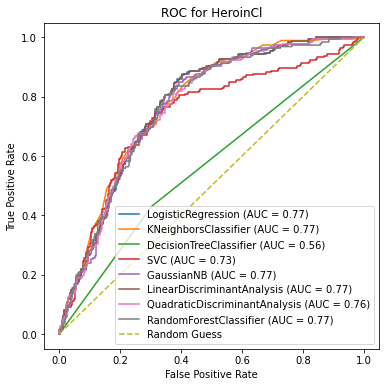

,Accuracy (%),Precision (%),Sensitivity (%),F1 Socre (%)
LogisticRegression,71.76,51.79,74.36,61.05
KNN,73.35,58.90,49.23,53.63
DecisionTree,61.32,39.25,43.08,41.08
SVM,72.07,56.95,44.10,49.71
Naive Bayes,71.43,54.91,48.72,51.63
LDA,71.11,55.17,41.03,47.06
QDA,71.91,55.81,49.23,52.32
Random Forest,70.63,58.57,21.03,30.94


In [40]:
split_train_evaluation_plot(pca, yHeroinPl, verbose=False, plot_cm=False, title="ROC for HeroinCl")

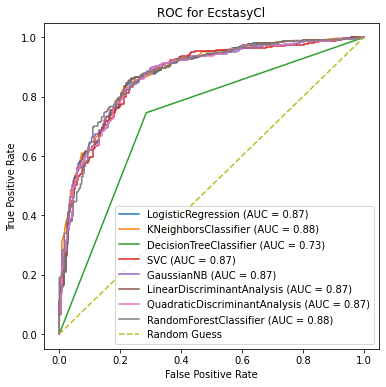

,Accuracy (%),Precision (%),Sensitivity (%),F1 Socre (%)
LogisticRegression,80.17,86.05,78.31,81.99
KNN,79.94,86.04,79.89,82.85
DecisionTree,73.35,80.11,74.60,77.26
SVM,79.94,85.04,81.22,83.09
Naive Bayes,80.74,85.44,82.28,83.83
LDA,80.58,85.99,81.22,83.54
QDA,78.97,85.80,78.31,81.88
Random Forest,79.29,87.61,76.72,81.81


In [41]:
split_train_evaluation_plot(pca, yEcstasyPl, verbose=False, plot_cm=False, title="ROC for EcstasyCl")

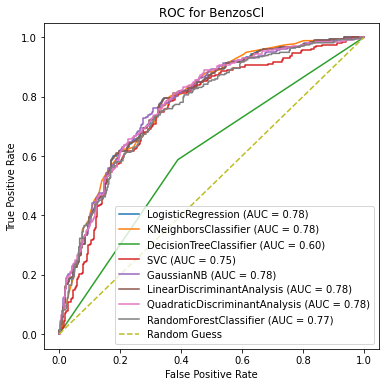

,Accuracy (%),Precision (%),Sensitivity (%),F1 Socre (%)
LogisticRegression,72.83,65.58,72.40,68.82
KNN,69.98,65.97,68.10,67.02
DecisionTree,60.03,55.03,58.78,56.85
SVM,69.98,65.75,68.82,67.25
Naive Bayes,71.59,68.35,68.10,68.22
LDA,70.79,68.16,65.23,66.67
QDA,71.11,67.62,68.10,67.86
Random Forest,70.14,65.35,70.97,68.04


In [42]:
split_train_evaluation_plot(pca, yBenzoPl, verbose=False, plot_cm=False, title="ROC for BenzosCl")

## Classification on Heroin Pleiade

In [43]:
# Train - Test split
X_train, X_test, y_train, y_test = train_test_split(pca, yHeroinPl, test_size=0.33, random_state=0)

### Logistic Regression

Accuracy: 73.94 %
Precision score: 0.6801546080444498
F1 score: 0.48929663608562685


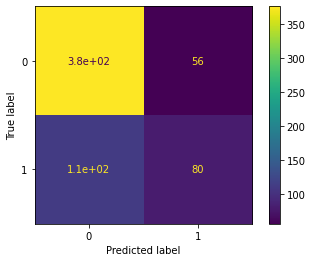

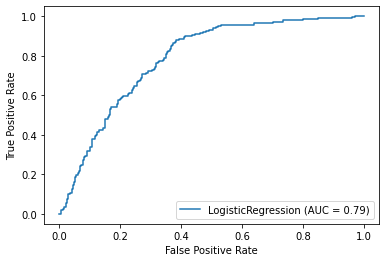

In [44]:
#%% Logistic regression
from sklearn.linear_model import LogisticRegression

# define the model
cls_lr = LogisticRegression(max_iter=1000)
# fit on the training set
cls_lr.fit(X_train, y_train)
# predict on test set
yhat = cls_lr.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, yhat, labels=cls_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_lr.classes_)
disp.plot() 

# Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
Accuracy = cross_val_score(estimator = cls_lr, X=X, y=yHeroinPl, cv = 10)
print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

# Precision = tp / (tp + fp) --> parlant
print("Precision score:", precision_score(y_test, yhat, average='macro'))

# Recall/Sensibilité/sensitivity = tp / (tp + fn)
#print("Recall/Sensibilité/sensitivity score:", recall_score(y_test, yhat))

# Specificity/Spécificité = tn / (tn + fp)

# F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
print("F1 score:", f1_score(y_test, yhat))

# Courbe ROC
plot_roc_curve(cls_lr, X_test, y_test)
plt.show()

### K-NN

104
La précision d'une estimation non biaisée du modèle est: 75.60192616372392


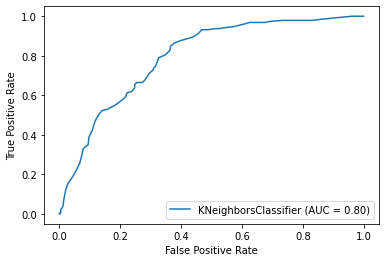

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# De 1 à 500 voisins (exclu), échelle logarithmique
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}

search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10)
search.fit(X_train, y_train)
print(search.best_params_['n_neighbors'])

y_pred = search.predict(X_test)
accuracy_score(y_pred, y_test)

print("La précision d'une estimation non biaisée du modèle est:", accuracy_score(y_pred, y_test)*100)

cls_knn = KNeighborsClassifier(n_neighbors=search.best_params_['n_neighbors'])
cls_knn.fit(X_train, y_train)
# Courbe ROC
plot_roc_curve(cls_knn, X_test, y_test)
plt.show()  # AUC=0.48, c'est null pour le modèle Logistic Regression

### Decision Tree

Accuracy: 66.61 %
Precision score: 45.03 %
Recall/Sensibilité/sensitivity score: 40.31 %
F1 score: 0.42541436464088395


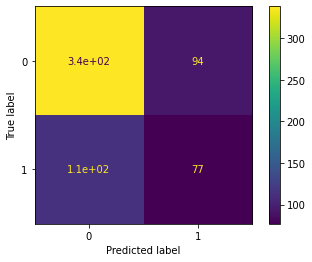

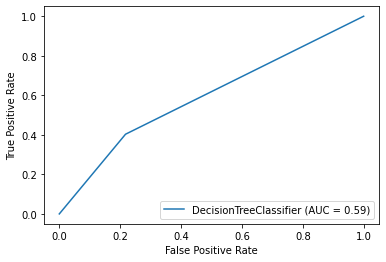

In [46]:
from sklearn.tree import DecisionTreeClassifier

cls_dt = DecisionTreeClassifier(criterion="gini", random_state=42)
cls_dt.fit(X_train, y_train)

y_pred_dt = cls_dt.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dt, labels=cls_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_dt.classes_)
disp.plot()

# Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
Accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

# Precision = tp / (tp + fp) --> parlant
print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_dt)*100))

# Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_dt)*100))

# Specificity/Spécificité = tn / (tn + fp) -> pas intéressant

# F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
print("F1 score:", f1_score(y_test, y_pred_dt))

# Courbe ROC
plot_roc_curve(cls_dt, X_test, y_test)
plt.show()

## Classification on Ecstasy Pleiade

In [47]:
# Train - Test split
X_train, X_test, y_train, y_test = train_test_split(X, yEcstasyPl, test_size=0.33, random_state=0)

### Logistic Regression

Accuracy: 83.25 %
Precision score: 0.8436411149825784
Recall/Sensibilité/sensitivity score: 0.8356545961002786
F1 score: 0.8633093525179857


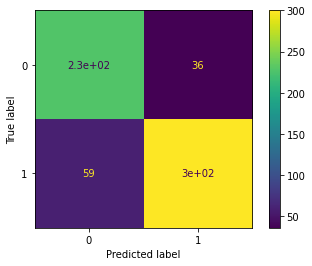

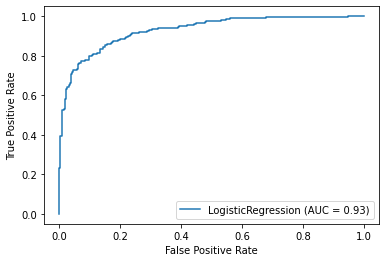

In [48]:
#%% Logistic regression
from sklearn.linear_model import LogisticRegression

# define the model
cls_lr = LogisticRegression(max_iter=1000)
# fit on the training set
cls_lr.fit(X_train, y_train)
# predict on test set
yhat = cls_lr.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, yhat, labels=cls_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_lr.classes_)
disp.plot() 

# Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
Accuracy = cross_val_score(estimator = cls_lr, X=X, y=yEcstasyPl, cv = 10)
print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

# Precision = tp / (tp + fp) --> parlant
print("Precision score:", precision_score(y_test, yhat, average='macro'))

# Recall/Sensibilité/sensitivity = tp / (tp + fn)
print("Recall/Sensibilité/sensitivity score:", recall_score(y_test, yhat))

# Specificity/Spécificité = tn / (tn + fp)

# F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
print("F1 score:", f1_score(y_test, yhat))

# Courbe ROC
plot_roc_curve(cls_lr, X_test, y_test)
plt.show()

### K-NN

11
La précision d'une estimation non biaisée du modèle est: 82.5040128410915


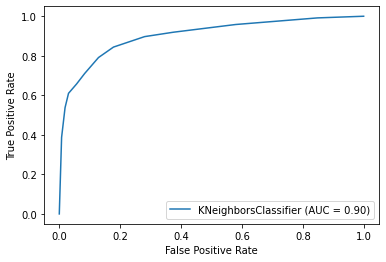

In [49]:

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# De 1 à 500 voisins (exclu), échelle logarithmique
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}

search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10)
search.fit(X_train, y_train)
print(search.best_params_['n_neighbors'])

y_pred = search.predict(X_test)
accuracy_score(y_pred, y_test)

print("La précision d'une estimation non biaisée du modèle est:", accuracy_score(y_pred, y_test)*100)

cls_knn = KNeighborsClassifier(n_neighbors=search.best_params_['n_neighbors'])
cls_knn.fit(X_train, y_train)
# Courbe ROC
plot_roc_curve(cls_knn, X_test, y_test)
plt.show()

### Decision Tree

Accuracy: 75.44 %
Precision score: 78.93 %
Recall/Sensibilité/sensitivity score: 78.27 %
F1 score: 0.786013986013986


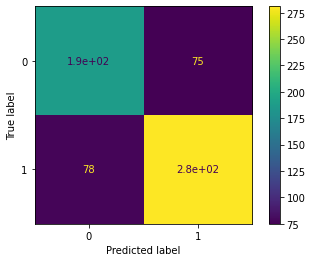

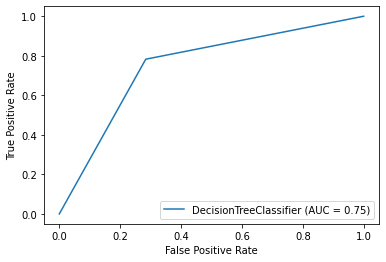

In [50]:
from sklearn.tree import DecisionTreeClassifier

cls_dt = DecisionTreeClassifier(criterion="gini", random_state=42)
cls_dt.fit(X_train, y_train)

y_pred_dt = cls_dt.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dt, labels=cls_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_dt.classes_)
disp.plot()

# Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
Accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

# Precision = tp / (tp + fp) --> parlant
print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_dt)*100))

# Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_dt)*100))

# Specificity/Spécificité = tn / (tn + fp) -> pas intéressant

# F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
print("F1 score:", f1_score(y_test, y_pred_dt))

# Courbe ROC
plot_roc_curve(cls_dt, X_test, y_test)
plt.show()

## Classification on Benzos 

In [51]:
# Train - Test split
X_train, X_test, y_train, y_test = train_test_split(X, yBenzoPl, test_size=0.33, random_state=0)

### Logistic Regression 

Accuracy: 73.74 %
Precision score: 0.7253351206434315
Recall/Sensibilité/sensitivity score: 0.6529850746268657
F1 score: 0.6756756756756757


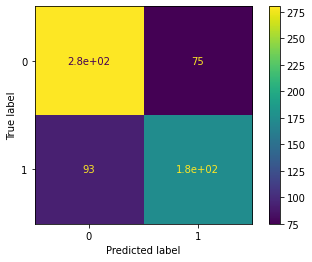

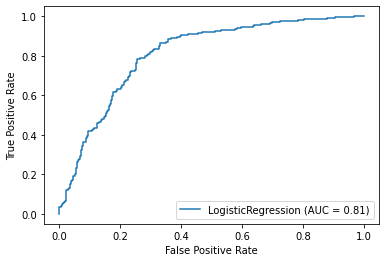

In [52]:
from sklearn.linear_model import LogisticRegression

# define the model
cls_lr = LogisticRegression(max_iter=1000)
# fit on the training set
cls_lr.fit(X_train, y_train)
# predict on test set
yhat = cls_lr.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, yhat, labels=cls_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_lr.classes_)
disp.plot() 

# Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
Accuracy = cross_val_score(estimator = cls_lr, X=X, y=yBenzoPl, cv = 10)
print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

# Precision = tp / (tp + fp) --> parlant
print("Precision score:", precision_score(y_test, yhat, average='macro'))

# Recall/Sensibilité/sensitivity = tp / (tp + fn)
print("Recall/Sensibilité/sensitivity score:", recall_score(y_test, yhat))

# Specificity/Spécificité = tn / (tn + fp)

# F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
print("F1 score:", f1_score(y_test, yhat))

# Courbe ROC
plot_roc_curve(cls_lr, X_test, y_test)
plt.show()

### K-NN

59
La précision d'une estimation non biaisée du modèle est: 72.3916532905297


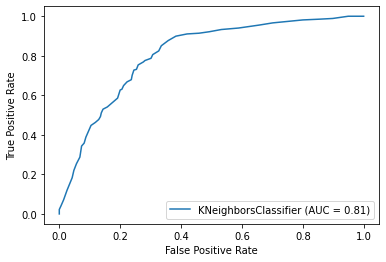

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# De 1 à 500 voisins (exclu), échelle logarithmique
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}

search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10)
search.fit(X_train, y_train)
print(search.best_params_['n_neighbors'])

y_pred = search.predict(X_test)
accuracy_score(y_pred, y_test)

print("La précision d'une estimation non biaisée du modèle est:", accuracy_score(y_pred, y_test)*100)


cls_knn = KNeighborsClassifier(n_neighbors=search.best_params_['n_neighbors'])
cls_knn.fit(X_train, y_train)
# Courbe ROC
plot_roc_curve(cls_knn, X_test, y_test)
plt.show()

### Decision Tree

Accuracy: 65.17 %
Precision score: 59.27 %
Recall/Sensibilité/sensitivity score: 60.82 %
F1 score: 0.6003683241252302


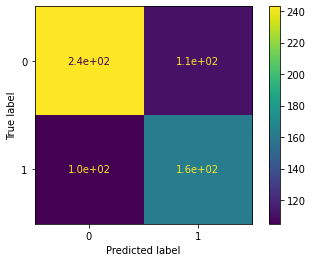

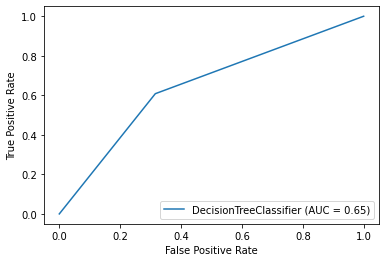

In [54]:
from sklearn.tree import DecisionTreeClassifier

cls_dt = DecisionTreeClassifier(criterion="gini", random_state=42)
cls_dt.fit(X_train, y_train)

y_pred_dt = cls_dt.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dt, labels=cls_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_dt.classes_)
disp.plot()

# Accuracy = (tn + tp) / (tn + fp + fn + tp) --> n'est pas assez parlant car class imbalanced
Accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy: {:.2f} %".format(Accuracy.mean()*100))

# Precision = tp / (tp + fp) --> parlant
print("Precision score: {:.2f} %".format(precision_score(y_test, y_pred_dt)*100))

# Recall/Sensibilité/sensitivity = tp / (tp + fn) -> plus intéressant 
print("Recall/Sensibilité/sensitivity score: {:.2f} %".format(recall_score(y_test, y_pred_dt)*100))

# Specificity/Spécificité = tn / (tn + fp) -> pas intéressant

# F1 score: à privilégier sur l’accuracy dans le cas d’une situation d’imbalanced classes
print("F1 score:", f1_score(y_test, y_pred_dt))

# Courbe ROC
plot_roc_curve(cls_dt, X_test, y_test)
plt.show()

**CONCLUSION** : On obtient de meilleures résultats que lorsque les drogues étaient toutes éparpillées ! C'est parce que les classes sont plus équilibrées. 